References:

1. https://github.com/xbresson/CS6208_2023/blob/main/codes/labs_lecture07/01_vanilla_graph_transformers.ipynb
2. https://github.com/xbresson/CS6208_2023/blob/main/codes/labs_lecture07/03_graph_transformers_regression_exercise.ipynb
3. https://github.com/pgniewko/pytorch_geometric/blob/master/torch_geometric/nn/conv/transformer_conv.py
4. https://arxiv.org/abs/2012.09699
5. https://arxiv.org/abs/1703.04977

TDC:
1. Test the model on this new set: https://practicalcheminformatics.blogspot.com/2023/06/getting-real-with-molecular-property.html

In [6]:
# Standard
import logging

# Third party
import numpy as np
import rdkit
from rdkit import RDLogger
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader

# GT-PyG
from gt_pyg.data.utils import (
    get_tensor_data, 
    get_node_dim, 
    get_edge_dim, 
    get_train_valid_test_data
)
from gt_pyg.nn.model import GraphTransformerNet

# Turn off majority of RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


# Set a random seed for a reproducibility purposes
torch.manual_seed(192837465)

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Log the used versions of RDkit and torch
print(f'Rdkit version: {rdkit.__version__}')
print(f'Torch version: {torch.__version__}')

Rdkit version: 2022.09.5
Torch version: 1.13.1


## Get the ADME@TDC data 

In [7]:
from tdc import utils
names = utils.retrieve_benchmark_names('ADMET_Group')
print(names)

['caco2_wang', 'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'lipophilicity_astrazeneca', 'solubility_aqsoldb', 'bbb_martins', 'ppbr_az', 'vdss_lombardo', 'cyp2d6_veith', 'cyp3a4_veith', 'cyp2c9_veith', 'cyp2d6_substrate_carbonmangels', 'cyp3a4_substrate_carbonmangels', 'cyp2c9_substrate_carbonmangels', 'half_life_obach', 'clearance_microsome_az', 'clearance_hepatocyte_az', 'herg', 'ames', 'dili', 'ld50_zhu']


In [8]:
PE_DIM = 6
(tr, va, te) = get_train_valid_test_data('caco2_wang', min_num_atoms=PE_DIM + 1)
tr_dataset = get_tensor_data(tr.Drug.to_list(), tr.Y.to_list(), pe_dim=PE_DIM)
va_dataset = get_tensor_data(va.Drug.to_list(), va.Y.to_list(), pe_dim=PE_DIM)
te_dataset = get_tensor_data(te.Drug.to_list(), te.Y.to_list(), pe_dim=PE_DIM)
NODE_DIM = get_node_dim()
EDGE_DIM = get_edge_dim()

print(f'Number of training examples: {len(tr_dataset)}')
print(f'Number of validation examples: {len(va_dataset)}')
print(f'Number of test examples: {len(te_dataset)}')

train_loader = DataLoader(tr_dataset, batch_size=64)
val_loader = DataLoader(va_dataset, batch_size=512)
test_loader = DataLoader(te_dataset, batch_size=512)

Found local copy...
Loading...
Done!
INFO:root:Removed 5 compounds that have more than 1 fragment.
INFO:root:Removed 9 compounds that did not meet the criteria.
INFO:root:Removed 1 compounds that have more than 1 fragment.
INFO:root:Removed 2 compounds that did not meet the criteria.
INFO:root:Removed 3 compounds that have more than 1 fragment.
INFO:root:Removed 4 compounds that did not meet the criteria.


Number of training examples: 628
Number of validation examples: 89
Number of test examples: 178


## Train and eval the GT model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=3, 
                            hidden_dim=128,
                            num_heads=16,
                            norm='bn',
                            aggregators=['sum','mean','max'],
                            dropout=0.0,
                            act='relu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model = torch_geometric.compile(model) 

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)


print(model)
print(f"Number of params: {model.num_parameters()//1000} k")

def train(epoch, loss_func):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0) 

        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader, loss_func):
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0) 
        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        total_error += loss_func(out.squeeze(), data.y).item()
    return total_error / len(loader.dataset)

train_loss = nn.L1Loss(reduction='mean')
test_loss = nn.L1Loss(reduction='sum')

for epoch in range(1, 21):
    tr_loss = train(epoch, loss_func=train_loss)
    va_loss = test(val_loader, loss_func=test_loss)
    te_loss = test(test_loader, loss_func=test_loss)
    scheduler.step(va_loss)
    print(f'Epoch: {epoch:02d}, Loss: {tr_loss:.4f}, Val: {va_loss:.4f}, '
          f'Test: {te_loss:.4f}')

GraphTransformerNet(
  (node_emb): Linear(in_features=79, out_features=128, bias=True)
  (edge_emb): Linear(in_features=10, out_features=128, bias=True)
  (pe_emb): Linear(in_features=6, out_features=128, bias=True)
  (gt_layers): ModuleList(
    (0): GTConv(128, 128, heads=16)
    (1): GTConv(128, 128, heads=16)
    (2): GTConv(128, 128, heads=16)
  )
  (global_pool): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    MaxAggregation(),
  ], mode=cat)
  (mu_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (log_var_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)
Number of params: 609 k
Epoch: 01, Loss: 2.4672, Val: 1.6095, Test: 1.7710
Epoch: 02, Loss: 1.2880, Val: 2.0807, Test: 2.2122
Epoch:

## STD vs ERROR

In [5]:
model.eval()

y_hat = []
y_exp = []
stds = []

for data in test_loader:
    data = data.to(device)
    batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0) 
    (out, std) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
    y_hat += list(out.squeeze().detach().numpy())
    y_exp += list(data.y.detach().numpy())
    stds += list(std.detach().numpy())

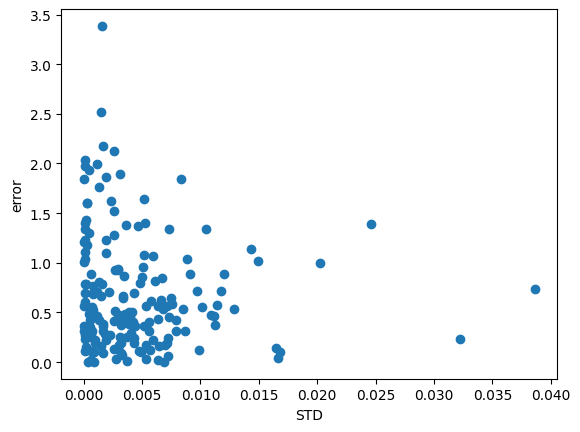

In [6]:
plt.scatter(stds, abs(np.array(y_hat) - np.array(y_exp)))
plt.xlabel('STD')
plt.ylabel('error')
plt.show()